In [1]:
import functions as fun
import numpy as np
import pandas as pd 
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.regularizers import l2



df = pd.read_csv("./housing_full.csv")

In [2]:
def import_housing_data(url):
  import pandas as pd
  df = pd.read_csv(url)
  df.drop(columns=["Id"], inplace=True)
  df.dropna(axis=1, inplace=True)

  for col in df:
    if col[0].isdigit():
      nums = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
      df.rename(columns={col:nums[int(col[0])]}, inplace=True)

  return df

In [3]:
df = import_housing_data("./housing_full.csv")

In [4]:
for col in df: 
  if not pd.api.types.is_any_real_numeric_dtype(df[col]):
    df = df.join(pd.get_dummies(df[col], prefix=col, drop_first=False).astype(int))
scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

df = df.select_dtypes(int)

In [5]:
y = price_scaler.fit_transform(df[['SalePrice']])

X = df.drop("SalePrice", axis=1)
X = scaler.fit_transform(X)

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.layers import Dropout

# Input layer
input_layer = keras.Input(shape=(X_train.shape[1],))

# First Dense and BatchNormalization layers without L2 Regularization
x = layers.Dense(128, kernel_initializer='he_normal')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = Dropout(0.4)(x)  # Adding a dropout layer with a dropout rate of 10%

# Additional Dense layers without L2 Regularization
x = layers.Dense(64, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = Dropout(0.4)(x)  # Adding a dropout layer with a dropout rate of 10%

x = layers.Dense(32, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = Dropout(0.4)(x)  # Adding a dropout layer with a dropout rate of 10%

# Output layer
output_layer = layers.Dense(1, activation='linear')(x)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)


In [7]:
model.compile(optimizer=keras.optimizers.legacy.Adam(0.0005), loss='mean_squared_error',  metrics=['mean_absolute_error', keras.metrics.RootMeanSquaredError() ])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=50, 
                               restore_best_weights=True)

In [9]:
history = model.fit(X_train, y_train, epochs=350, batch_size=32, validation_data=(X_dev, y_dev),  callbacks=[early_stopping])

Epoch 1/350
37/37 [==============================] - 1s 8ms/step - loss: 1.2791 - mean_absolute_error: 0.8737 - root_mean_squared_error: 1.1310 - val_loss: 0.0626 - val_mean_absolute_error: 0.2062 - val_root_mean_squared_error: 0.2502
Epoch 2/350
37/37 [==============================] - 0s 3ms/step - loss: 0.9721 - mean_absolute_error: 0.7597 - root_mean_squared_error: 0.9859 - val_loss: 0.0631 - val_mean_absolute_error: 0.2109 - val_root_mean_squared_error: 0.2513
Epoch 3/350
37/37 [==============================] - 0s 3ms/step - loss: 0.7678 - mean_absolute_error: 0.6870 - root_mean_squared_error: 0.8762 - val_loss: 0.0683 - val_mean_absolute_error: 0.2168 - val_root_mean_squared_error: 0.2613
Epoch 4/350
37/37 [==============================] - 0s 3ms/step - loss: 0.7045 - mean_absolute_error: 0.6520 - root_mean_squared_error: 0.8393 - val_loss: 0.0729 - val_mean_absolute_error: 0.2282 - val_root_mean_squared_error: 0.2701
Epoch 5/350
37/37 [==============================] - 0s 6ms/

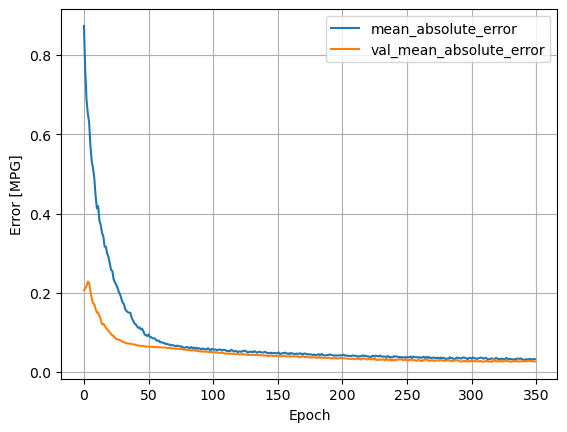

In [10]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
def plot_mae(history):
  plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)  
#plot_loss(history)
plot_mae(history)

In [11]:
loss, mae, maep = model.evaluate(X_dev, y_dev)
train_loss, train_mae, train_maep = model.evaluate(X_train, y_train)

print(f"Test Loss: {loss}")
scaled_mae = mae
scaled_train_mae = train_mae
original_mae = scaled_mae * (price_scaler.data_max_ - price_scaler.data_min_)
original_train_mae = scaled_train_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original MAE: {mae}")
print(f"Original train MAE: {train_mae}")
print(f"Original MAPE: {maep}")
print(f"Original train MAPE: {train_maep}")

print(f"Scaled MAE: {original_mae[0]}")
print(f"Scaled train MAE: {original_train_mae[0]}")


37/37 [==============================] - 0s 696us/step - loss: 4.6148e-04 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0215
Test Loss: 0.0019245275761932135
Original MAE: 0.026437580585479736
Original train MAE: 0.014824481680989265
Original MAPE: 0.043869439512491226
Original train MAPE: 0.021482080221176147
Scaled MAE: 19037.701779603958
Scaled train MAE: 10675.10925848037


In [12]:
from sklearn.metrics import r2_score

# Making predictions on the test set
y_pred_train = model.predict(X_train)
y_pred_dev = model.predict(X_dev)
r2_train = r2_score(y_train, y_pred_train)
r2_dev = r2_score(y_dev, y_pred_dev)
print(f"R2 - Train Score: {r2_train}")
print(f"R2 - Dev Score: {r2_dev}")


10/10 [==============================] - 0s 690us/step
R2 - Train Score: 0.9598800332986982
R2 - Dev Score: 0.8698944154978302


In [13]:
n_train = y_dev.shape[0]  
p_train = y_dev.shape[1] 

n_dev = y_dev.shape[0]  
p_dev = y_dev.shape[1] 

adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
print(f"Adjusted R2 Score: {adjusted_r2_train}")

adjusted_r2_dev = 1 - (1 - r2_dev) * (n_dev - 1) / (n_dev - p_dev - 1)
print(f"Adjusted R2 Score: {adjusted_r2_dev}")



Adjusted R2 Score: 0.9597416885859351
Adjusted R2 Score: 0.869445775551271
